## Import librerie, risorse e dataset


In [20]:
import numpy as np
import pandas as pd
import re
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D
# from tensorflow.keras.layers import SpatialDropout1D, LeakyReLU, Bidirectional, Lambda, Multiply, Activation, Permute, Flatten, RepeatVector, Concatenate
from tensorflow.keras.layers import SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import pickle

output_dir = './model_results'
os.makedirs(output_dir, exist_ok=True)

In [14]:
dataset_paths = '../Filter_Toxic_Comments_dataset.csv'
data = pd.read_csv(dataset_paths)

## Modello Deep Learning

Parte 1:
Preprocessing del testo: Converte il testo in minuscolo, rimuove caratteri speciali mantenendo lettere, spazi e punteggiatura importante poi gestisce valori nulli e infine imuove spazi multipli

Parte 2-5:
Analisi e preparazione dei dati: Tokenizzazione del testo, creazione di sequenze con padding e split dei dati in training (80%) e validation (20%), infine creazione clss weight bilanciati

Parte 6:
Architettura del modello LSTM con:
- Layer di embedding con dimensione 100
- Layer LSTM bidirezionale con 128 unità
- GlobalMaxPooling sui risultati LSTM
- Dropout (0.3) e BatchNormalization
- Dense layer con 128 unità e attivazione ReLU
- Output layer con attivazione sigmoid per classificazione multi-label

Parte 7:
Strategie di training
- batch size di 128 per maggiore stabilità
- Adam optimizer con learning rate 0.001
- Early Stopping con patience=3
- ReduceLROnPlateau per ridurre il learning rate quando necessario
- ModelCheckpoint per salvare la versione migliore

Parte 8:
Ottimizzazione soglie nella validation:
- soglie più basse (0.3) per classi rare
- ottimizzato rispetto a F1-score

Parte 9:
Valutazione del modello:
- precision, recall e F1-score
- matrici di confusione

Parte 10:
Visualizzazione e salvataggio
- grafici di training e validation accuracy/loss
- salvataggio



In [15]:
# 1. PREPROCESSING DEL TESTO
def preprocess_text(text):
    # Gestione valori NaN
    text = str(text) if pd.notna(text) else ""
    # Conversione a minuscolo
    text = text.lower()
    # Rimozione caratteri speciali ma mantenimento di spazi e punteggiatura
    text = re.sub(r'[^\w\s\.\!\?]', ' ', text)
    # Rimozione spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Assicuriamoci che la colonna dei commenti esista
comment_column = 'comment_text' if 'comment_text' in data.columns else data.columns[0]
data['processed_comment'] = data[comment_column].apply(preprocess_text)

In [16]:
# 2. CONFIGURAZIONE E ANALISI DATI
# Identifichiamo le colonne
all(cat in data.columns for cat in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

critical_categories = ['threat', 'identity_hate'] if all(cat in categories for cat in ['threat', 'identity_hate']) else []

#distribuzione classi
for category in categories:
    count = data[category].sum()
    total = len(data)
    print(f"{category}: {count} campioni ({count/total*100:.2f}%)")


toxic: 15294 campioni (9.58%)
severe_toxic: 1595 campioni (1.00%)
obscene: 8449 campioni (5.29%)
threat: 478 campioni (0.30%)
insult: 7877 campioni (4.94%)
identity_hate: 1405 campioni (0.88%)


In [17]:
# 3. CAMPIONAMENTO STRATIFICATO PER FARE I TEST
# # Prendiamo un sottoinsieme più piccolo ma bilanciato per fare i test
# subset_size = 100000  # Dimensione del sottoinsieme

# if len(data) > subset_size:
#     print(f"\nDataset: ({len(data)}")

#     # Identifica gli indici di tutti gli esempi delle classi critiche
#     critical_indices = []
#     if critical_categories:
#         for category in critical_categories:
#             critical_indices.extend(data[data[category] == 1].index.tolist())

#         critical_indices = list(set(critical_indices))  # Rimuovi duplicati
#         print(f"Inclusi {len(critical_indices)} esempi dalle classi critiche")

#     # Identifica indici non critici per campionamento casuale
#     non_critical_indices = list(set(data.index) - set(critical_indices))
#     n_remaining = min(subset_size - len(critical_indices), len(non_critical_indices))

#     # Campionamento casuale per gli esempi rimanenti
#     if n_remaining > 0:
#         random_indices = np.random.choice(non_critical_indices, n_remaining, replace=False)
#         selected_indices = np.concatenate([critical_indices, random_indices])
#     else:
#         selected_indices = critical_indices[:subset_size]  # Limita se ci sono troppe istanze critiche

#     # Crea il sottoinsieme stratificato
#     data = data.loc[selected_indices].reset_index(drop=True)
#     print(f"Dimensione del sottoinsieme finale: {len(data)}")

# Report sulla distribuzione delle classi critiche
if critical_categories:
    for category in critical_categories:
        count = data[category].sum()
        total = len(data)
        print(f"Classe critica '{category}': {count} esempi ({count/total*100:.2f}%)")

#utilizziamo tutti i dati disponibili
print(f"Utilizzando tutti i {len(data)} esempi per il training")

Classe critica 'threat': 478 esempi (0.30%)
Classe critica 'identity_hate': 1405 esempi (0.88%)
Utilizzando tutti i 159571 esempi per il training


In [18]:
# 4. PREPARAZIONE DATI
max_features = 20000  # Dimensione vocabolario
maxlen = 100          # Lunghezza massima sequenza

# Tokenizzazione
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['processed_comment'])
sequences = tokenizer.texts_to_sequences(data['processed_comment'])
X = pad_sequences(sequences, maxlen=maxlen)

#formato corretto
all(cat in data.columns for cat in categories)
y = data[categories].values

# Split dei dati
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(y) < 10000 else None)
print(f"Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}")

Training: 127656, Validation: 31915


In [19]:
# 5. CALCOLO CLASS WEIGHTS BILANCIATI
class_weights = {}

for i, category in enumerate(categories):
    # Calcolo pesi inversamente proporzionali alla frequenza
    pos_weight = len(y_train) / (2 * np.sum(y_train[:, i])) if np.sum(y_train[:, i]) > 0 else 1.0
    neg_weight = len(y_train) / (2 * (len(y_train) - np.sum(y_train[:, i]))) if len(y_train) - np.sum(y_train[:, i]) > 0 else 1.0

    # Limitare i pesi per evitare instabilità
    pos_weight = min(pos_weight, 10.0)
    neg_weight = min(neg_weight, 10.0)

    # Definire i class weights
    class_weights[i] = {0: neg_weight, 1: pos_weight}

    print(f"{category}: peso classe positiva = {pos_weight:.2f}, peso classe negativa = {neg_weight:.2f}")


toxic: peso classe positiva = 5.22, peso classe negativa = 0.55
severe_toxic: peso classe positiva = 10.00, peso classe negativa = 0.51
obscene: peso classe positiva = 9.48, peso classe negativa = 0.53
threat: peso classe positiva = 10.00, peso classe negativa = 0.50
insult: peso classe positiva = 10.00, peso classe negativa = 0.53
identity_hate: peso classe positiva = 10.00, peso classe negativa = 0.50


In [26]:
# 6. CREAZIONE MODELLO LSTM

def create_balanced_model():
    # Input layer
    input_layer = Input(shape=(maxlen,))

    # Embedding layer
    embedding = Embedding(
        input_dim=min(max_features, len(tokenizer.word_index) + 1),
        output_dim=100,
        input_length=maxlen,
        embeddings_regularizer=l2(1e-6)
    )(input_layer)

    # SpatialDropout1D
    spatial_dropout = SpatialDropout1D(0.2)(embedding)

    # LSTM bidirezionale
    lstm = Bidirectional(LSTM(64, return_sequences=True,
                              dropout=0.2, recurrent_dropout=0.2))(spatial_dropout)

    # Pooling
    pooled = GlobalMaxPooling1D()(lstm)

    # Fully connected layers
    dropout1 = Dropout(0.3)(pooled)
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(dropout1)
    bn = BatchNormalization()(dense1)
    dropout2 = Dropout(0.3)(bn)

    # Output layer
    output = Dense(len(categories), activation='sigmoid')(dropout2)

    # Creazione modello
    model = Model(inputs=input_layer, outputs=output)

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [28]:
# 7. TRAINING CON GESTIONE CUSTOM
model = create_balanced_model()
model.summary()

# Callbacks con monitor di accuracy
callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        min_delta=0.001
    ),
    # Learning rate reduction con monitor accuracy
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=2,
        min_lr=0.0001,
        verbose=1,
        mode='max'
    ),
    # Salvataggio modello
  ModelCheckpoint(
      filepath=os.path.join(output_dir, 'best_model.weights.h5'),
      monitor='val_accuracy',
      save_best_only=True,
      save_weights_only=True,
      verbose=1,
      mode='max'
  )
]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    callbacks=callbacks,
    class_weight=class_weights[0],
    verbose=1
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, 100, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_5                  │ (None, 100, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 100, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,102,278 (8.02 MB)

 Trainable params: 2,102,022 (8.02 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.3522 - loss: 0.1992
Epoch 1: val_accuracy improved from -inf to 0.99411, saving model to ./model_results/best_model.weights.h5
499/499 ━━━━━━━━━━━━━━━━━━━━ 530s 1s/step - accuracy: 0.3527 - loss: 0.1990 - val_accuracy: 0.9941 - val_loss: 0.1029 - learning_rate: 0.0010
Epoch 2/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.9327 - loss: 0.0330
Epoch 2: val_accuracy did not improve from 0.99411
499/499 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.9327 - loss: 0.0330 - val_accuracy: 0.9940 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 3/10
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.9358 - loss: 0.0298
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_accuracy did not improve from 0.99411
499/499 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - accuracy: 0.9358 - loss: 0.0298 - val_accuracy: 0.9939 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 4/10
499/499 ━━━━━

In [29]:
# 8. OTTIMIZZAZIONE SOGLIE PER CLASSI SBILANCIATE

# Predizione su validation set
val_pred = model.predict(X_val)

def optimize_thresholds(val_pred, y_val, categories, critical_categories):
    """Ottimizza le soglie di decisione per massimizzare F1-score"""
    optimized_thresholds = []

    for i, category in enumerate(categories):
        # Gestisci il caso in cui non ci siano esempi positivi
        if np.sum(y_val[:, i]) == 0:
            print(f"{category}: non ci sono esempi positivi nel validation set, soglia impostata a 0.5")
            optimized_thresholds.append(0.5)
            continue

        best_f1 = 0
        best_threshold = 0.5

        # Per le classi critiche soglie più basse
        start_threshold = 0.3 if category in critical_categories else 0.4

        # Test diverse soglie
        for threshold in np.arange(start_threshold, 0.7, 0.05):
            y_pred_binary = (val_pred[:, i] >= threshold).astype(int)
            f1 = f1_score(y_val[:, i], y_pred_binary, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        optimized_thresholds.append(best_threshold)
        print(f"{category}: soglia ottimale = {best_threshold:.2f} (F1-score = {best_f1:.4f})")

    return optimized_thresholds

# Ottimizzazione soglie
optimized_thresholds = optimize_thresholds(val_pred, y_val, categories, critical_categories)

# Salvataggio soglie
thresholds_path = os.path.join(output_dir, 'optimized_thresholds.pickle')
with open(thresholds_path, 'wb') as handle:
    pickle.dump(optimized_thresholds, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Soglie ottimizzate, in: {thresholds_path}")


998/998 ━━━━━━━━━━━━━━━━━━━━ 56s 55ms/step
toxic: soglia ottimale = 0.40 (F1-score = 0.2113)
severe_toxic: soglia ottimale = 0.50 (F1-score = 0.0000)
obscene: soglia ottimale = 0.40 (F1-score = 0.0116)
threat: soglia ottimale = 0.50 (F1-score = 0.0000)
insult: soglia ottimale = 0.50 (F1-score = 0.0000)
identity_hate: soglia ottimale = 0.50 (F1-score = 0.0000)
Soglie ottimizzate, in: ./model_results/optimized_thresholds.pickle


In [30]:
# 9. VALUTAZIONE SUL VALIDATION SET

# Applicazione soglie ottimizzate
y_pred_optimized = np.zeros_like(val_pred, dtype=int)
for i, threshold in enumerate(optimized_thresholds):
    y_pred_optimized[:, i] = (val_pred[:, i] >= threshold).astype(int)

# Calcolo metriche
results = []
for i, category in enumerate(categories):
    # Calcola metriche solo se ci sono esempi positivi
    if np.sum(y_val[:, i]) > 0:
        f1 = f1_score(y_val[:, i], y_pred_optimized[:, i], zero_division=0)
        recall = recall_score(y_val[:, i], y_pred_optimized[:, i], zero_division=0)
        precision = precision_score(y_val[:, i], y_pred_optimized[:, i], zero_division=0)

        # Calcola F2 per le classi critiche
        f2 = fbeta_score(y_val[:, i], y_pred_optimized[:, i], beta=2, zero_division=0) if category in critical_categories else 0

        # Calcola confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_val[:, i], y_pred_optimized[:, i], labels=[0,1]).ravel()
    else:
        f1, recall, precision, f2 = 0, 0, 0, 0
        tn, fp, fn, tp = 0, 0, 0, 0

    #risultati
    print(f"{category}:")
    print(f"  F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
    if category in critical_categories:
        print(f"  F2={f2:.4f} (metrica prioritaria per questa classe)")
    print(f"  TP={tp}, FP={fp}, FN={fn}, TN={tn}")

    # Salva
    result_dict = {
        'category': category,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'tp': int(tp),
        'fp': int(fp),
        'fn': int(fn),
        'tn': int(tn)
    }

    if category in critical_categories:
        result_dict['f2'] = f2

    results.append(result_dict)

# Salvataggio risultati
results_df = pd.DataFrame(results)
results_path = os.path.join(output_dir, 'evaluation_results.csv')
results_df.to_csv(results_path, index=False)
print(f"Risultati di valutazione salvati in: {results_path}")

toxic:
  F1=0.2113, Precision=1.0000, Recall=0.1181
  TP=361, FP=0, FN=2695, TN=28859
severe_toxic:
  F1=0.0000, Precision=0.0000, Recall=0.0000
  TP=0, FP=0, FN=321, TN=31594
obscene:
  F1=0.0116, Precision=0.9091, Recall=0.0058
  TP=10, FP=1, FN=1705, TN=30199
threat:
  F1=0.0000, Precision=0.0000, Recall=0.0000
  F2=0.0000 (metrica prioritaria per questa classe)
  TP=0, FP=0, FN=74, TN=31841
insult:
  F1=0.0000, Precision=0.0000, Recall=0.0000
  TP=0, FP=0, FN=1614, TN=30301
identity_hate:
  F1=0.0000, Precision=0.0000, Recall=0.0000
  F2=0.0000 (metrica prioritaria per questa classe)
  TP=0, FP=0, FN=294, TN=31621
Risultati di valutazione salvati in: ./model_results/evaluation_results.csv


## Risultato modello

Grafici salvati in: ./model_results/training_curves.png
Tokenizer salvato in: ./model_results/tokenizer.pickle


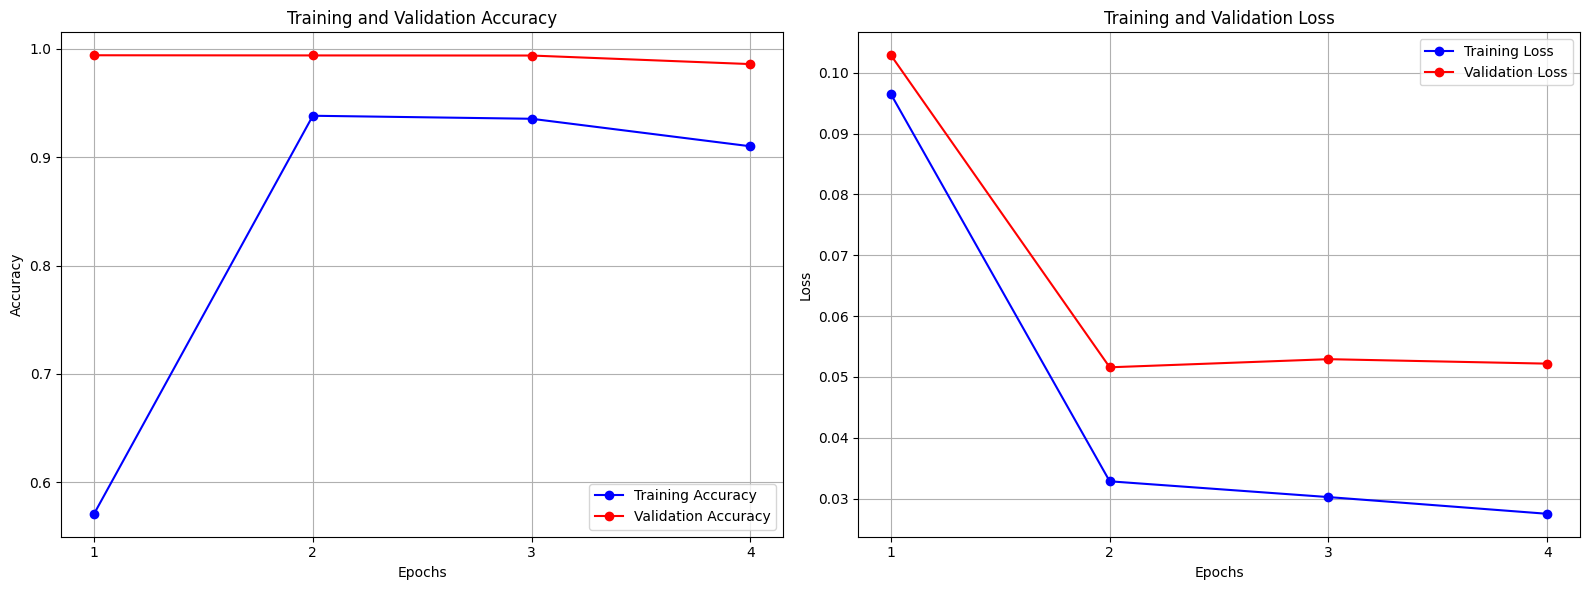

In [31]:
# 10. VISUALIZZAZIONE CURVE DI TRAINING

# Raccolta dati dalle metriche
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)

# Creazione subplots (accuracy e loss)
plt.figure(figsize=(16, 6))
#accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)

#loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)

plt.tight_layout()
curves_path = os.path.join(output_dir, 'training_curves.png')
plt.savefig(curves_path, dpi=300)
print(f"Grafici salvati in: {curves_path}")

#Salvataggio del tokenizer
tokenizer_path = os.path.join(output_dir, 'tokenizer.pickle')
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Tokenizer salvato in: {tokenizer_path}")




Il modello sta apprendendo efficacemente, come dimostrato dalla diminuzione delle loss e dall'alta accuratezza. In particolare:

Grafico Accuracy

La validation accuracy (linea rossa) si mantiene estremamente alta, quasi al 100% in tutte le epoche, con un leggero calo nell'ultima epoca ma comunque sopra il 98%.
La training accuracy (linea blu) parte da circa il 57% e cresce rapidamente fino al 94% nella seconda epoca, mantenendosi poi stabile con una leggera flessione nell'ultima epoca.
La differenza tra training e validation accuracy nella prima epoca è molto ampia, ma poi si riduce significativamente

Grafico Loss

Entrambe le loss partono da circa 0.10 e diminuiscono rapidamente.
La training loss (blu) scende più velocemente della validation loss, raggiungendo un valore molto basso di circa 0.03.
La validation loss (rossa) si stabilizza intorno a 0.05 dopo la seconda epoca